### PROBLEM 2: Implement t-SNE dim reduction, run on MNIST dataset. 

In [2]:
# Load MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values.astype(np.float32)
labels = mnist.target.values.astype(np.float32)

# Sample 10000 images
indices = np.random.choice(X.shape[0], 10000, replace=False)
X = X[indices]
labels = labels[indices]


/usr/local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


/var/folders/2d/kjz0bk3s5nj4p4v10t35f8f40000gn/T/ipykernel_6921/2297197756.py:52: RuntimeWarning: divide by zero encountered in log
  ConstKL = np.sum(P * np.log(P))
/var/folders/2d/kjz0bk3s5nj4p4v10t35f8f40000gn/T/ipykernel_6921/2297197756.py:52: RuntimeWarning: invalid value encountered in multiply
  ConstKL = np.sum(P * np.log(P))
/var/folders/2d/kjz0bk3s5nj4p4v10t35f8f40000gn/T/ipykernel_6921/2297197756.py:79: RuntimeWarning: divide by zero encountered in log
  cost = ConstKL - np.sum(P * np.log(Q))
/var/folders/2d/kjz0bk3s5nj4p4v10t35f8f40000gn/T/ipykernel_6921/2297197756.py:79: RuntimeWarning: invalid value encountered in multiply
  cost = ConstKL - np.sum(P * np.log(Q))


Iteration 0: error is nan


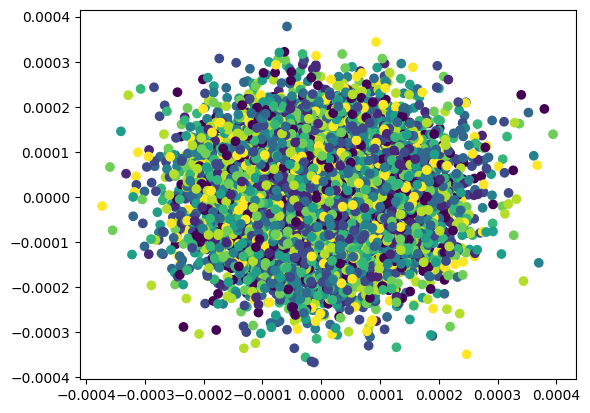

Iteration 10: error is nan


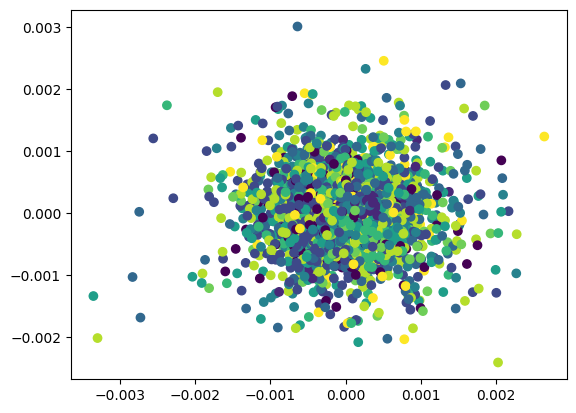

Iteration 20: error is nan


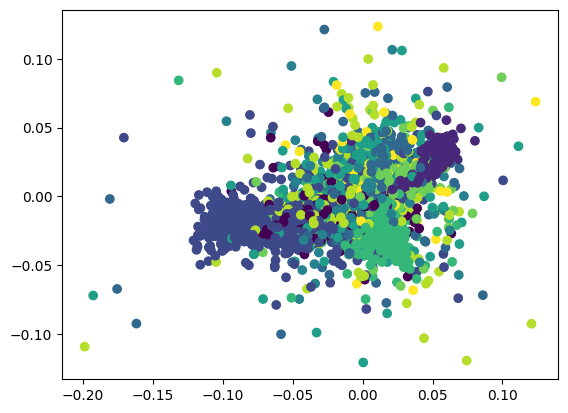

Iteration 30: error is nan


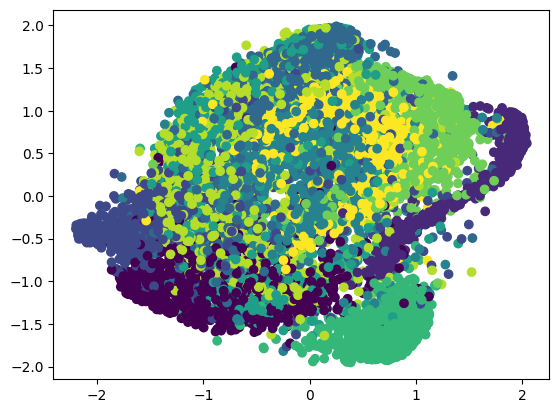

Iteration 40: error is nan


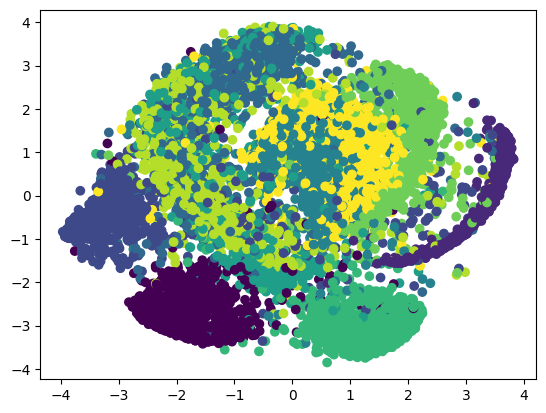

Iteration 50: error is nan


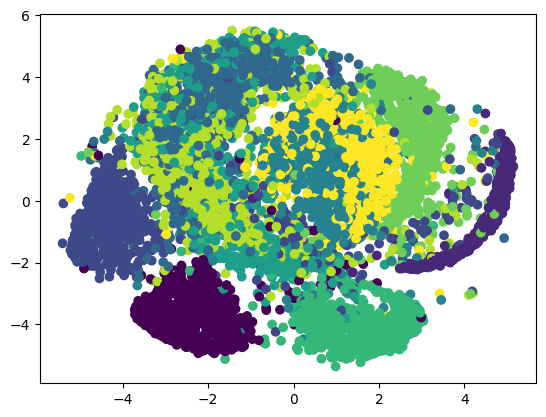

Iteration 60: error is nan


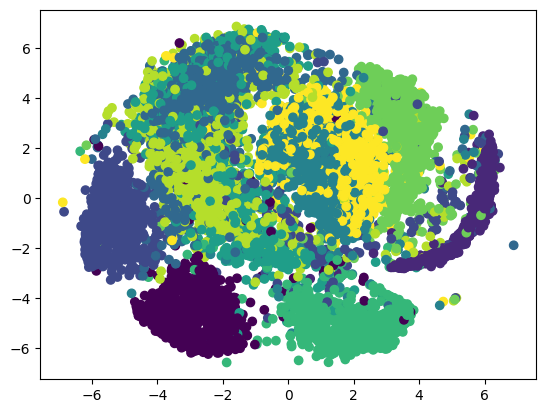

Iteration 70: error is nan


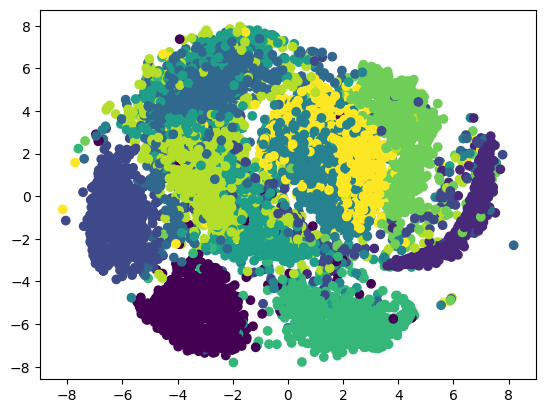

Iteration 80: error is nan


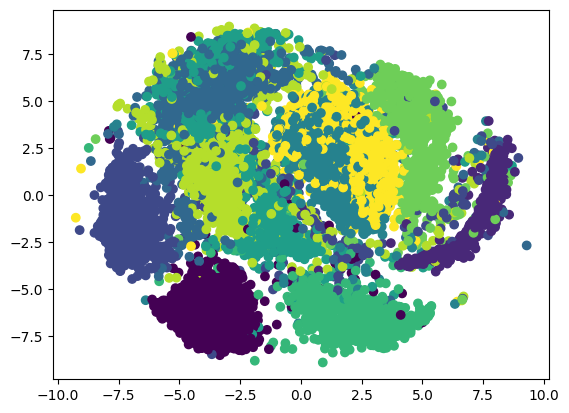

Iteration 90: error is nan


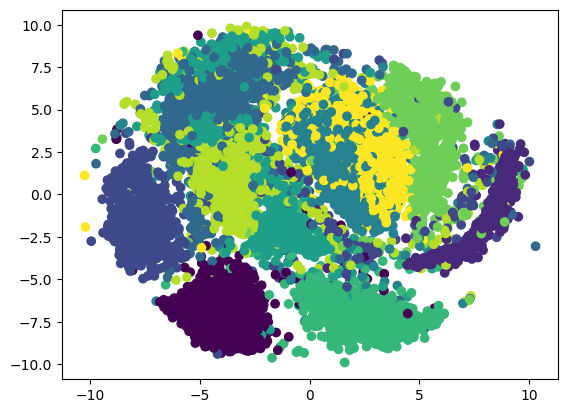

Iteration 100: error is nan


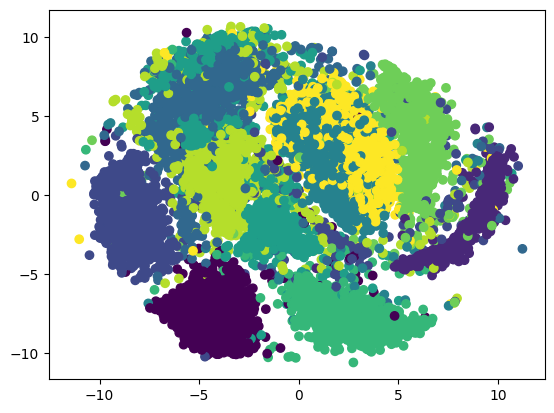

Iteration 110: error is nan


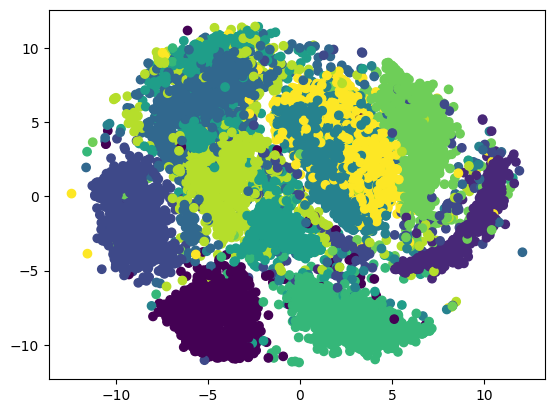

Iteration 120: error is nan


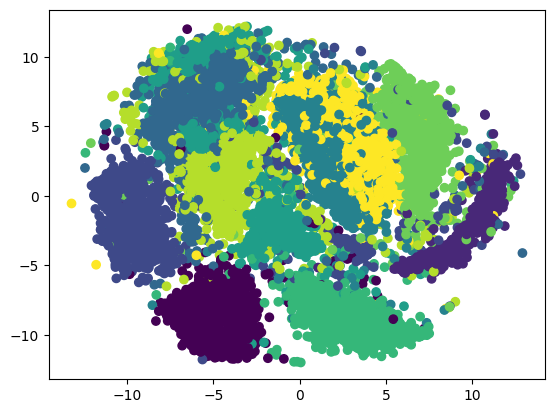

Iteration 130: error is nan


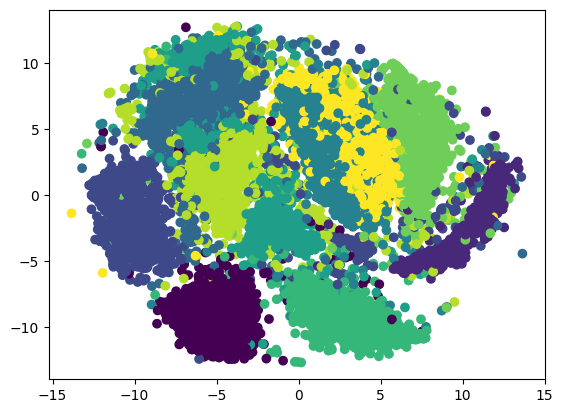

Iteration 140: error is nan


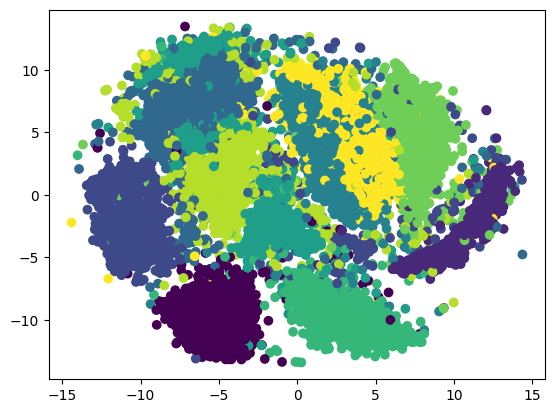

Iteration 150: error is nan


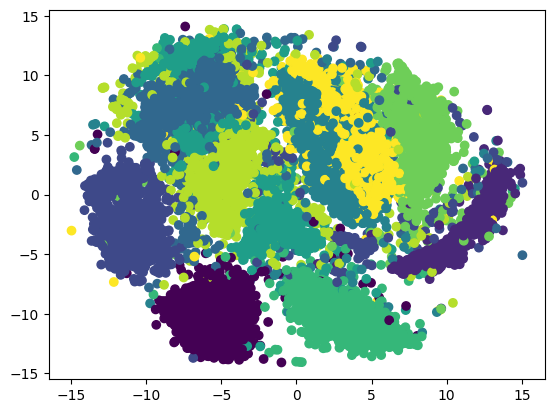

Iteration 160: error is nan


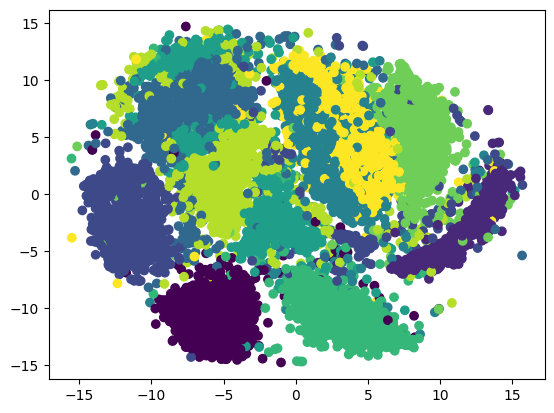

Iteration 170: error is nan


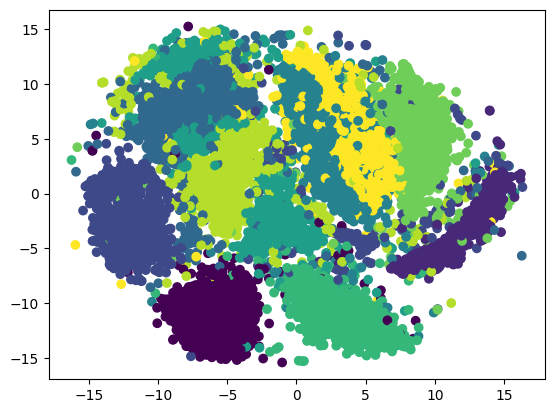

Iteration 180: error is nan


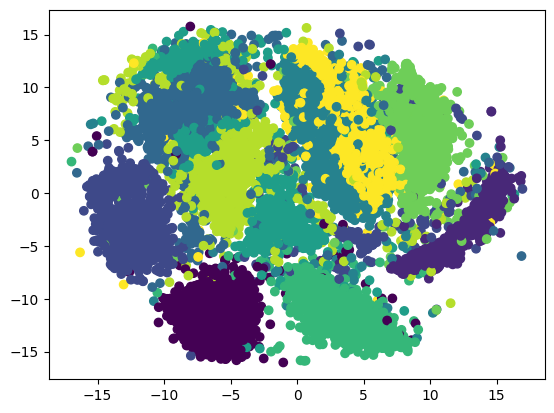

Iteration 190: error is nan


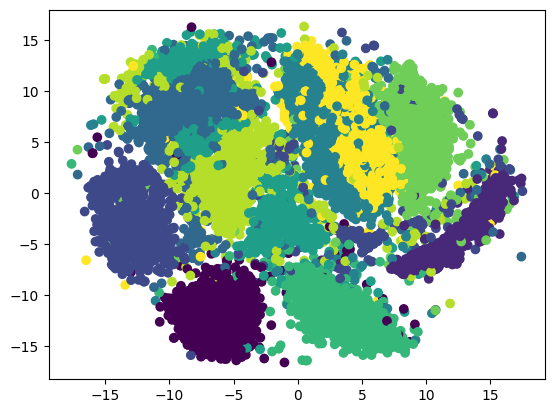

Iteration 200: error is nan


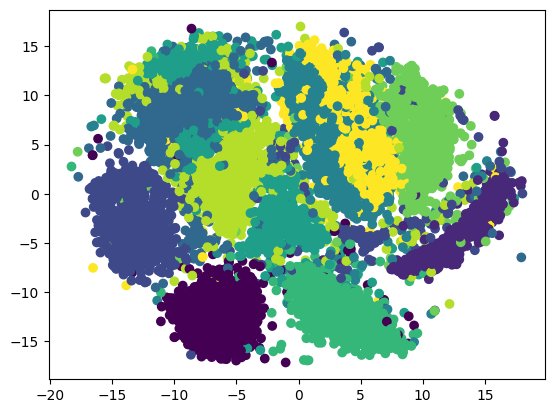

Iteration 210: error is nan


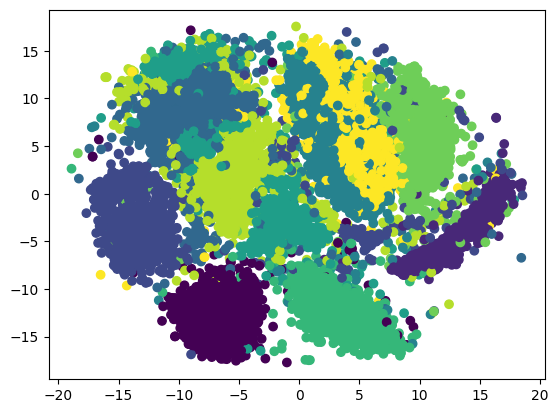

Iteration 220: error is nan


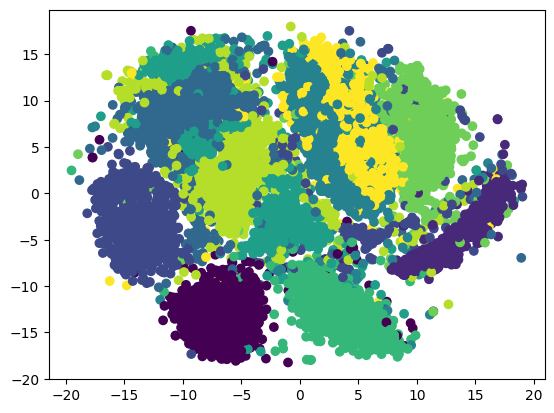

Iteration 230: error is nan


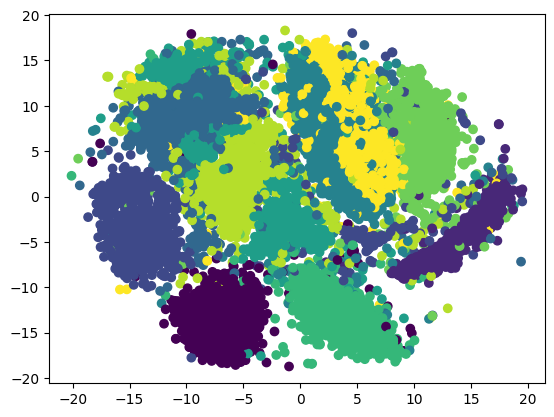

Iteration 240: error is nan


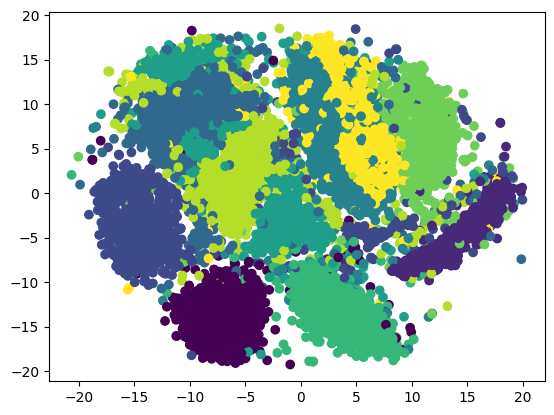

Iteration 250: error is nan


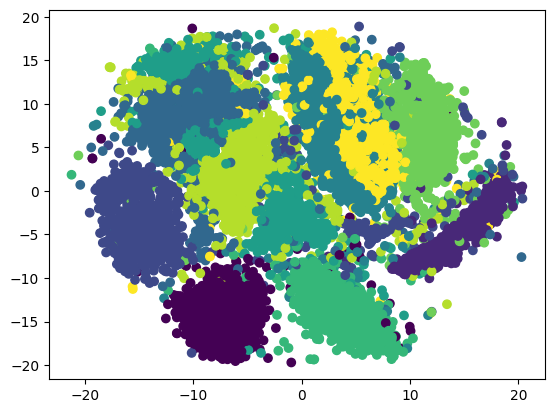

In [ ]:
# Prep X
X -= np.min(X)
X /= np.max(X)
X -= np.mean(X, axis=0)

N, F = X.shape
no_dims = 2
PCA_dims = 50
use_momentum = 1

# Run PCA
pca = PCA(n_components=PCA_dims)
X = pca.fit_transform(X)

# Compute pairwise distance
sum_X = np.sum(X**2, axis=1)
D = np.add.outer(sum_X, sum_X) - 2 * np.dot(X, X.T)

# Compute the similarities p_ij for each row i
P = np.zeros((N, N))
beta = np.ones((N,))
for i in range(N):
    trials = 0
    Hdiff = 1
    betamin = -np.inf
    betamax = np.inf
    while abs(Hdiff) > 1e-5 and trials < 50:
        P_i = np.exp(-D[i] * beta[i])
        sumP = np.sum(P_i)
        H = np.log(sumP) + beta[i] * np.sum(D[i] * P_i) / sumP
        Hdiff = H - np.log2(30)
        if Hdiff > 0:
            betamin = beta[i]
            if betamax == np.inf:
                beta[i] *= 2
            else:
                beta[i] = (beta[i] + betamax) / 2
        else:
            betamax = beta[i]
            if betamin == -np.inf:
                beta[i] /= 2
            else:
                beta[i] = (beta[i] + betamin) / 2
        trials += 1
    P[i] = P_i / sumP

# Make sure P is correct
np.fill_diagonal(P, 0)
P = (P + P.T) / 2
P /= np.sum(P)

ConstKL = np.sum(P * np.log(P))

# Initialize tSNE
max_iter = 400
epsilon = 500
min_gain = .01
y = .0001 * np.random.randn(N, no_dims)
y_incs = np.zeros_like(y)
gains = np.ones_like(y)

# Run tSNE iterations
for iter in range(max_iter):
    sum_y2 = np.sum(y**2, axis=1)
    Qnum = 1 / (1 + np.add.outer(sum_y2, sum_y2) - 2 * np.dot(y, y.T))
    np.fill_diagonal(Qnum, 0)
    Q = Qnum / np.sum(Qnum)
    L = (P - Q) * Qnum
    y_grads = 4 * (np.diag(np.sum(L, axis=1)) - L).dot(y)
    if use_momentum:
        gains = (gains + .2) * (np.sign(y_grads) != np.sign(y_incs)) + (gains * .8) * (np.sign(y_grads) == np.sign(y_incs))
        gains[gains < min_gain] = min_gain
        y_incs = - epsilon * (gains * y_grads)
    else:
        y_incs = -epsilon * y_grads
    y += y_incs
    y -= np.mean(y, axis=0)
    if iter % 10 == 0:
        cost = ConstKL - np.sum(P * np.log(Q))
        print(f'Iteration {iter}: error is {cost}')
        plt.scatter(y[:, 0], y[:, 1], c=labels)
        plt.show()

